In [1]:
import tensorflow as tf
import numpy as np

from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

2024-07-05 07:00:16.346562: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-05 07:00:16.454406: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-05 07:00:16.454478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-05 07:00:16.464100: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-05 07:00:16.497286: I tensorflow/core/platform/cpu_feature_guar

## 데이터셋

In [2]:
# stanford_dogs 데이터셋
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

# label 수 저장(120)
num_classes = ds_info.features["label"].num_classes
print(num_classes)

120


2024-07-05 07:00:21.102361: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8098 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:17:00.0, compute capability: 8.0


### 데이터 전처리

In [3]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    # 0~image_size 사이의 random값 생성
    # [] : scalar값 의미
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    # x_min : 중심 x로부터 width/2만큼 이전의 위치
    # y_min : 중심 y로부터 height/2만큼 이전의 위치
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

def mix_2_images_labels(
    image_a, image_b, 
    label_a, label_b,
    x_min, y_min, x_max, y_max,
    num_classes=120
):
    # image 크기 추출
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 

    # image_a에 image_b(y_min~y_max, x_min~x_max)로 채우기
    middle_left = image_a[y_min:y_max, 0:x_min, :]
    middle_center = image_b[y_min:y_max, x_min:x_max, :]
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :]

    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)

    # ratio = middle_center 너비(mixed_area) / image 너비
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_img, mixed_label

def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    # batch size 내의 image를 cutmix
    for i in range(batch_size):
        # 1번째 데이터 추출
        image_a = image[i]
        label_a = label[i]

        # random index를 통한 2번째 데이터 추출
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]

        # mixed image, label 추출
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

        mixed_img, mixed_label = mix_2_images_labels(
            image_a, image_b, label_a, label_b,
            x_min, y_min, x_max, y_max
        )
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels
    

In [4]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    # ratio : 0~1 사이 랜덤값 추출
    ratio = tf.random.uniform([], 0, 1)
    
    # one-hot encoding
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)

    # image_b를 기준으로 ratio 적용
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [5]:
# image 정규화
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

# image 증강
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

# one-hot encoding
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(
    ds, is_test=False, batch_size=16, 
    with_aug=False, with_cutmix=False, with_mixup=False
):
    # 정규화
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    
    # augmentation
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )

    # batch size 설정
    ds = ds.batch(batch_size)

    # cutmix인 경우
    # cutmix 내에 label이 one-hot encoding(mixed label)으로 변환
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    # mixup인 경우
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    # cutmix가 아닌 경우
    # one-hot encoding 사용
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 데이터셋 종류
- No Augmentation
- 기본 Augmentation
- 기본 Augmentation + Cutmix 적용
- 기본 Augmentation + Mixup 적용

In [6]:
# base
ds_train_base = apply_normalize_on_dataset(
    ds_train, is_test=False, batch_size=16, 
    with_aug=False, with_cutmix=False, with_mixup=False 
)
# augmentation만 적용
ds_train_aug = apply_normalize_on_dataset(
    ds_train, is_test=False, batch_size=16, 
    with_aug=True, with_cutmix=False, with_mixup=False 
)
# augmentation + cutmix
ds_train_aug_cutmix = apply_normalize_on_dataset(
    ds_train, is_test=False, batch_size=16, 
    with_aug=True, with_cutmix=True, with_mixup=False 
)
# augmentation + mixup
ds_train_aug_mixup = apply_normalize_on_dataset(
    ds_train, is_test=False, batch_size=16, 
    with_aug=True, with_cutmix=False, with_mixup=True 
)

ds_test = apply_normalize_on_dataset(
    ds_test, is_test=True, batch_size=16, 
    with_aug=False, with_cutmix=False, with_mixup=False 
)

## Resnet 50 모델 정의

In [7]:
# base datasets model
resnet50_base = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
# augmentation datasets model
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
# augmentation + cutmix datasets model
resnet50_aug_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
# augmentation + mixup model
resnet50_aug_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [8]:
def model_compile(model):
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        metrics=['accuracy'],
    )
    return model

In [9]:
def model_fit(model, train, test, ds_info, epochs):
    history = model.fit(
        train,
        steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
        validation_steps=int(ds_info.splits['test'].num_examples/16),
        epochs=epochs,
        validation_data=test,
        verbose=1,
        use_multiprocessing=True
    )
    return history, model

In [10]:
resnet50_base = model_compile(resnet50_base)
resnet50_aug = model_compile(resnet50_aug)
resnet50_aug_cutmix = model_compile(resnet50_aug_cutmix)
resnet50_aug_mixup = model_compile(resnet50_aug_mixup)

In [11]:
EPOCHS = 20

In [ ]:
history_base, resnet50_base = model_fit(resnet50_base, ds_train_base, ds_test, ds_info, EPOCHS)

In [ ]:
history_aug, resnet50_aug = model_fit(resnet50_aug, ds_train_base, ds_test, ds_info, EPOCHS)

In [ ]:
history_aug_cutmix, resnet50_aug_cutmix = model_fit(resnet50_aug_cutmix, ds_train_base, ds_test, ds_info, EPOCHS)

In [ ]:
history_aug_mixup, resnet50_aug_mixup = model_fit(resnet50_aug_mixup, ds_train_base, ds_test, ds_info, EPOCHS)

## Model 및 History 저장

In [ ]:
model_path='model/'

resnet50_base.save(model_path+'resnet50_base.h5')
resnet50_aug.save(model_path+'resnet50_aug.h5')
resnet50_aug_cutmix.save(model_path+'resnet50_aug_cutmix.h5')
resnet50_aug_mixup.save(model_path+'resnet50_aug_mixup.h5')

In [ ]:
import json

def save_historyModel(history, name):
    history_path = 'history/'
    with open(history_path + name, 'w') as f:
        json.dump(history.history, f)

In [ ]:
save_historyModel(history_base, 'base.json')
save_historyModel(history_aug, 'only_aug.json')
save_historyModel(history_aug_cutmix, 'aug_cutmix.json')
save_historyModel(history_aug_mixup, 'aug_mixup.json')

## 비교

In [12]:
model_path='model/'

resnet50_base = tf.keras.models.load_model(model_path+'resnet50_base.h5')
resnet50_aug = tf.keras.models.load_model(model_path+'resnet50_aug.h5')
resnet50_aug_cutmix = tf.keras.models.load_model(model_path+'resnet50_aug_cutmix.h5')
resnet50_aug_mixup = tf.keras.models.load_model(model_path+'resnet50_aug_mixup.h5')

In [13]:
import json

history_path = 'history/'

def get_history(name):
    with open(history_path+name+'.json', 'r') as f:
        history = json.load(f)
    return history

In [14]:
history_base = get_history('base')
history_aug = get_history('only_aug')
history_aug_cutmix = get_history('aug_cutmix')
history_aug_mixup = get_history('aug_mixup')

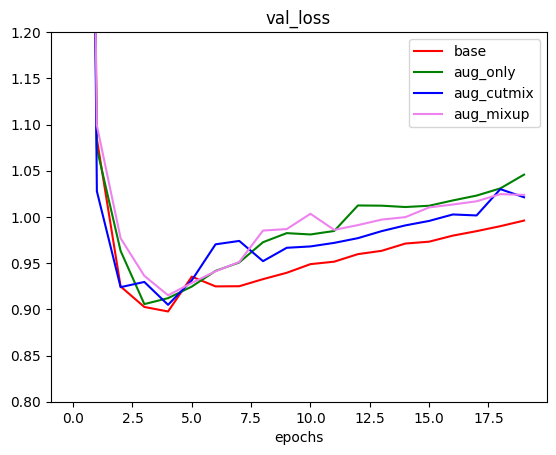

In [15]:
# val loss
plt.plot(history_base['val_loss'], 'r', label='base')
plt.plot(history_aug['val_loss'], 'g', label='aug_only')
plt.plot(history_aug_cutmix['val_loss'], 'b', label='aug_cutmix')
plt.plot(history_aug_mixup['val_loss'], 'violet', label='aug_mixup')
plt.xlabel('epochs')
plt.title('val_loss')
plt.ylim(0.8,1.2)
plt.legend()
plt.show()

**val_loss 비교**
- 의외로 base 가장 loss가 낮음
- aug_only가 가장 loss가 높음
- 이와 비슷하게 aug_cutmix와 aug_mixup은 aug보다는 낮지만 base보다는 높게 loss가 형성
    - aug를 기본적인 좌우 뒤집기 및 밝기 조절만 해서 오히려 다양한 표현을 하려던 것이 반대로 이미지의 특징을 가리게 되는 현상이 되었나?

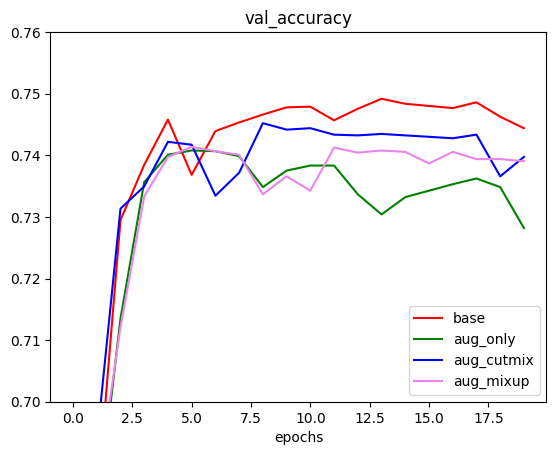

In [16]:
# val loss
plt.plot(history_base['val_accuracy'], 'r', label='base')
plt.plot(history_aug['val_accuracy'], 'g', label='aug_only')
plt.plot(history_aug_cutmix['val_accuracy'], 'b', label='aug_cutmix')
plt.plot(history_aug_mixup['val_accuracy'], 'violet', label='aug_mixup')
plt.xlabel('epochs')
plt.title('val_accuracy')
plt.ylim(0.7,0.76)
plt.legend()
plt.show()

**val_accuracy**
- val_loss의 형태와 비슷하게 나옴
- only_aug를 brightness 대신 다른 aug기법을 사용해 보는 것이 좋을듯.

## 회고

### 배운점
- 다양한 Augmentation의 기법을 알게 됨.

### 아쉬운 점
- augment method 구현을 너무 단순하게만 시도한 듯 하다.
    - 현재 augmentation을 한 데이터셋의 모델이 오히려 accuracy가 낮게 나오는 현상이 있음
    - 이것이 추측컨데 flip_left_right만으로는 이미지의 다양한 표현을 하기엔 한계가 있고,
    - brightness가 오히려 이미지 특징 추출에 방해가 되는 요소로 작용하지 않았나 생각 중.
    - 이후 시간이 되면 더 시도해보자.
- 4가지 모델을 학습하는데 시간이 너무 오래 걸림
    - 오래 걸리다보니 중간에 끊기는 현상도 있어서 어려움을 많이 겪음.